In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

import optuna
import xgboost as xgb
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor,AdaBoostClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, VotingClassifier,ExtraTreesRegressor,AdaBoostRegressor,GradientBoostingRegressor)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import class_weight
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from sklearn.svm import SVR
from sklearn import datasets, linear_model
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder


import eli5
from eli5.sklearn import PermutationImportance
import time



### Process the data

In [45]:
df = pd.read_csv("merged.csv")

def dropping_duplicates(data):
    data.drop_duplicates(inplace = True)

df.drop(columns='Unnamed: 10')
dropping_duplicates(df)
df.replace(' ',np.nan,inplace=True)
df.columns

Index(['Year', 'Province_x', 'City', 'GDP_captia', 'population', 'PBC',
       'Before', 'PCPC', 'Post', 'Post_1', 'mayor', 'mayor_tenure',
       'mayor_turnover', 'mayor_age', 'mayor_education', 'mayor_corruption',
       'secret', 'secret_tenure', 'secret_turnover', 'secret_age',
       'secret_education', 'secret_corruption', 't', 'GDP', 'GDP_growth',
       'First', 'Second', 'Third', 'Prov_code_x', 'Province_y', 'City_code_x',
       'light_mean', 'light_sum', 'light_min', 'light_max', 'light_std',
       'Province', 'Prov_code_y', 'City_code_y', 'PM_mean', 'PM_sum', 'PM_min',
       'PM_max', 'PM_std', 'Unnamed: 10'],
      dtype='object')

In [46]:
dataset = df[['City','Province','population','GDP','First', 'Second','Third','light_mean', 'light_sum',
              'light_min', 'light_max', 'light_std','PM_mean', 'PM_sum', 'PM_min', 'PM_max', 'PM_std']]
dataset['GDP'] = pd.to_numeric(df['GDP'])
dataset = dataset[dataset['GDP']!=0]
dataset = dataset.reset_index(drop=True)
le = LabelEncoder()
dataset['City_encoded'] = le.fit_transform(dataset['City'])
dataset = dataset.reset_index(drop=True)
dataset = dataset.drop(columns='City')
dataset


C:\Users\10621\AppData\Local\Temp\ipykernel_14964\416986198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['GDP'] = pd.to_numeric(df['GDP'])


,Province,population,GDP,First,Second,Third,light_mean,light_sum,light_min,light_max,light_std,PM_mean,PM_sum,PM_min,PM_max,PM_std,City_encoded
0,安徽省,607.89,4942100.0,19.10,42.27,38.63,291.559690,4396137.0,0.0,6030.0,603.245583,46.906599,5.864263e+05,28.299999,61.700001,7.822311,77
1,安徽省,610.99,5876612.0,19.12,41.37,39.51,338.169335,4858817.0,0.0,6117.0,622.270181,53.054223,6.632839e+05,35.000000,67.500000,7.870043,77
2,安徽省,613.89,7047175.0,19.05,42.44,38.52,347.235809,4997765.0,0.0,5834.0,599.247638,51.639594,6.455982e+05,33.299999,64.099998,7.638953,77
3,安徽省,614.89,7706600.0,18.52,46.89,34.59,292.531081,4277682.0,0.0,5450.0,560.327760,49.854047,6.232753e+05,32.299999,63.700001,7.234225,77
4,安徽省,615.75,9881100.0,15.74,53.03,31.23,342.196546,4834895.0,0.0,5359.0,514.517106,50.520133,6.316027e+05,31.900000,64.199997,7.854230,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3910,贵州省,782.80,18743600.0,14.27,45.92,39.81,164.962328,4956953.0,0.0,5197.0,426.648885,44.499399,1.258042e+06,35.599998,57.400002,4.224163,239
3911,贵州省,790.19,21683400.0,16.11,44.77,39.12,198.132985,5160968.0,0.0,5397.0,456.474641,38.253189,1.081456e+06,32.200001,51.799999,3.010072,239
3912,贵州省,798.00,24039400.0,15.41,44.22,40.37,194.865783,5599858.0,0.0,5448.0,457.481190,37.364108,1.056321e+06,30.700001,50.599998,3.393374,239
3913,贵州省,804.00,27485900.0,0.00,0.00,0.00,159.082824,4863321.0,0.0,5312.0,456.503318,32.709639,9.247342e+05,24.700001,47.099998,3.884749,239


In [47]:
### function t check the missing value
def miss_values_check(data):
    print(f'\033[0;33;40m A number of NaN values in  is {data.isnull().sum().sum()} \033[0;30;0m')
    if data.isnull().sum().sum() >0:
        sns.heatmap(data.isnull())


In [49]:
### One-hot Encoding ready
num_cols = ['population','GDP','First', 'Second','Third','light_mean', 'light_sum',
              'light_min', 'light_max', 'light_std','PM_mean', 'PM_sum', 'PM_min', 'PM_max', 'PM_std','City_encoded']

cat_cols = ['Province']


ohe = OneHotEncoder(handle_unknown='ignore',sparse = False,drop="first")
dataset_temp=pd.DataFrame(ohe.fit_transform(dataset[cat_cols]),columns=ohe.get_feature_names_out())

dataset_train=pd.concat([dataset.drop(cat_cols,axis=1),dataset_temp],axis=1) 
dataset.dropna()


,Province,population,GDP,First,Second,Third,light_mean,light_sum,light_min,light_max,light_std,PM_mean,PM_sum,PM_min,PM_max,PM_std,City_encoded
0,安徽省,607.89,4942100.0,19.10,42.27,38.63,291.559690,4396137.0,0.0,6030.0,603.245583,46.906599,5.864263e+05,28.299999,61.700001,7.822311,77
1,安徽省,610.99,5876612.0,19.12,41.37,39.51,338.169335,4858817.0,0.0,6117.0,622.270181,53.054223,6.632839e+05,35.000000,67.500000,7.870043,77
2,安徽省,613.89,7047175.0,19.05,42.44,38.52,347.235809,4997765.0,0.0,5834.0,599.247638,51.639594,6.455982e+05,33.299999,64.099998,7.638953,77
3,安徽省,614.89,7706600.0,18.52,46.89,34.59,292.531081,4277682.0,0.0,5450.0,560.327760,49.854047,6.232753e+05,32.299999,63.700001,7.234225,77
4,安徽省,615.75,9881100.0,15.74,53.03,31.23,342.196546,4834895.0,0.0,5359.0,514.517106,50.520133,6.316027e+05,31.900000,64.199997,7.854230,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3910,贵州省,782.80,18743600.0,14.27,45.92,39.81,164.962328,4956953.0,0.0,5197.0,426.648885,44.499399,1.258042e+06,35.599998,57.400002,4.224163,239
3911,贵州省,790.19,21683400.0,16.11,44.77,39.12,198.132985,5160968.0,0.0,5397.0,456.474641,38.253189,1.081456e+06,32.200001,51.799999,3.010072,239
3912,贵州省,798.00,24039400.0,15.41,44.22,40.37,194.865783,5599858.0,0.0,5448.0,457.481190,37.364108,1.056321e+06,30.700001,50.599998,3.393374,239
3913,贵州省,804.00,27485900.0,0.00,0.00,0.00,159.082824,4863321.0,0.0,5312.0,456.503318,32.709639,9.247342e+05,24.700001,47.099998,3.884749,239


In [50]:
X = dataset_train.drop(columns=['GDP','City_encoded'])
Y = dataset_train['GDP']
group = dataset_train['City_encoded']

 Rejection 8 points  


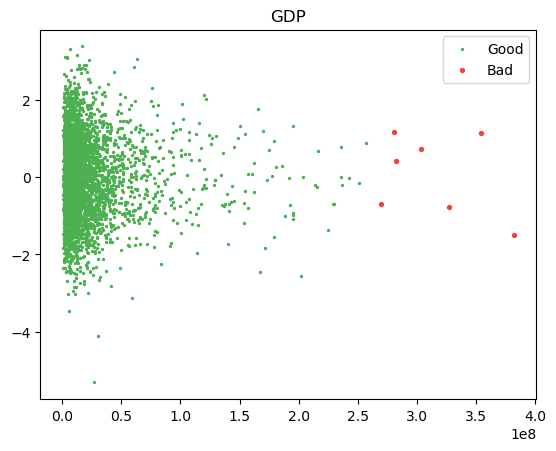

In [51]:
def plot_outliers(data,target,group,df, feature, threshold=8):
    mean, std = np.mean(df), np.std(df)
    z_score = np.abs((df-mean) / std)
    good = z_score < threshold
    print(f"\033[0;33;40m Rejection {(~good).sum()} points \033[0;30;0m ")
    visual_scatter = np.random.normal(size=df.size)
    plt.scatter(df[good], visual_scatter[good], s=2, label="Good", color="#4CAF50")
    plt.scatter(df[~good], visual_scatter[~good], s=8, label="Bad", color="#F44336")
    plt.legend(loc='upper right')
    plt.title(feature)
    plt.show();
    data,target,group = data[good],target[good],group[good]
    return data,target,group

X,Y,group = plot_outliers(data=X,target=Y,group=group,df=dataset_train['GDP'],feature='GDP')
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)
group = group.reset_index(drop=True)

### Permutation Importance

In [52]:
model = lgb.LGBMRegressor(n_estimators=100)
metric = 'neg_root_mean_squared_error'
permute = PermutationImportance(model,random_state=2023,n_iter =10,cv=5,scoring=metric).fit(X=X, y=Y)
eli5.show_weights(permute, feature_names = X.columns.tolist(),top=50)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3411
[LightGBM] [Info] Number of data points in the train set: 3907, number of used features: 39
[LightGBM] [Info] Start training from score 19852293.257487
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3404
[LightGBM] [Info] Number of data points in the train set: 3125, number of used features: 39
[LightGBM] [Info] Start training from score 20942475.321440
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3404
[LightGBM] [Info] Number of data points in the train set: 3125, number of used features: 38
[LightGBM] [Info

Weight,Feature
9427055.9082 ± 2448899.1364,light_sum
3232600.0173 ± 2367436.7185,population
2610732.0572 ± 1585861.7842,First
1821586.2550 ± 1473931.0211,light_std
683409.8589 ± 967990.8603,light_mean
651011.9683 ± 785821.5672,Third
524197.4642 ± 996186.1153,PM_sum
296603.1236 ± 571141.0724,Second
285447.0276 ± 841354.5843,light_max
187916.8103 ± 388628.0050,PM_max


In [9]:
model = xgb.XGBRegressor(n_estimators=100)
metric = 'neg_root_mean_squared_error'
permute = PermutationImportance(model,random_state=2023,n_iter =10,cv=5,scoring=metric).fit(X=X, y=Y)
eli5.show_weights(permute, feature_names = X.columns.tolist(),top=50)

Weight,Feature
8982929.1812 ± 5464228.8099,light_sum
3253166.0438 ± 2220960.8670,population
3179046.6464 ± 2639828.8795,First
1933439.7208 ± 5522398.4434,Third
1661379.3803 ± 2304689.4827,light_std
891562.2769 ± 1601126.5177,light_mean
487940.8828 ± 1378573.4098,PM_sum
294028.3852 ± 229739.1816,Year_2018
249607.9172 ± 240552.2870,Year_2019
243381.7324 ± 687446.7784,PM_min


 Rejection 13 points  


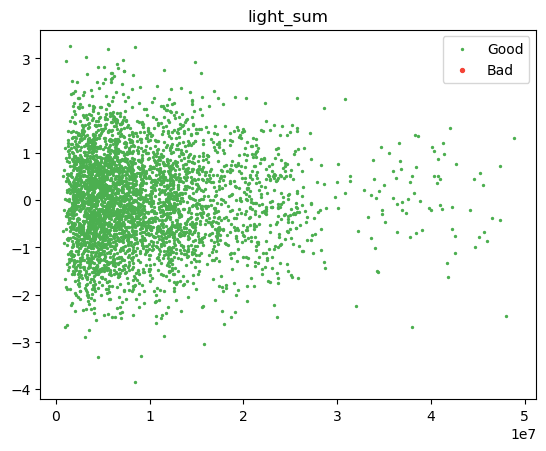

In [53]:
X,Y,group = plot_outliers(data=X,target=Y,group=group,df=X['light_sum'],feature='light_sum')
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)
group = group.reset_index(drop=True)

 Rejection 24 points  


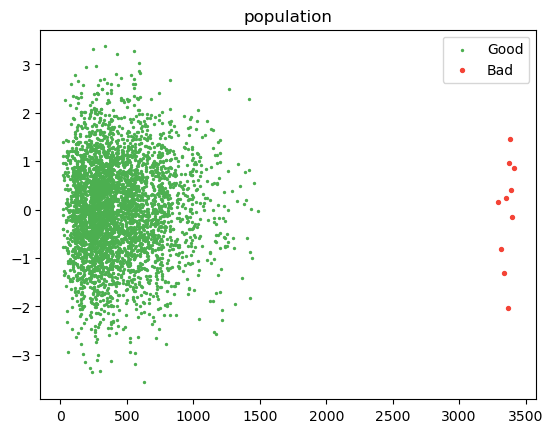

In [54]:
X,Y,group = plot_outliers(data=X,target=Y,group=group,df=X['population'],feature='population')
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)
group = group.reset_index(drop=True)

 Rejection 0 points  


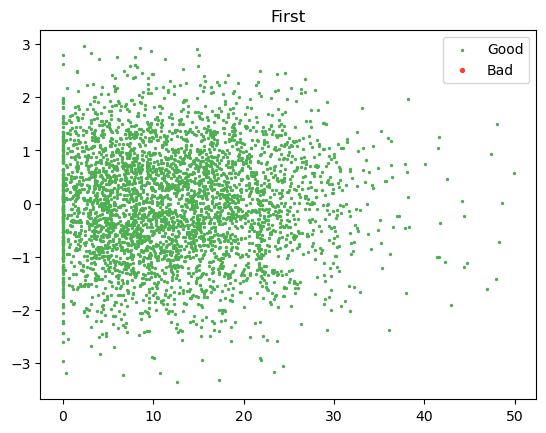

In [55]:
X,Y,group= plot_outliers(data=X,target=Y,group=group,df=X['First'],feature='First')
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)
group=group.reset_index(drop=True)

 Rejection 0 points  


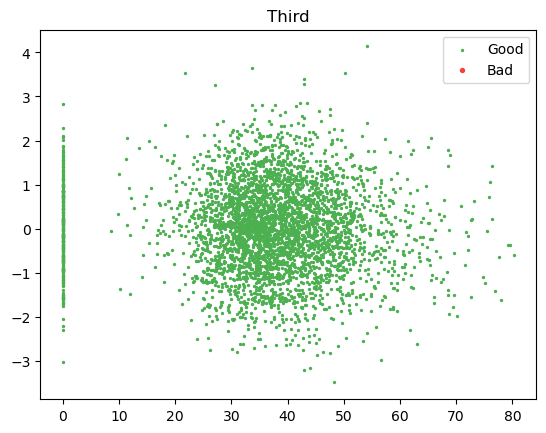

In [56]:
X,Y,group= plot_outliers(data=X,target=Y,group=group,df=X['Third'],feature='Third')
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)
group=group.reset_index(drop=True)

 Rejection 0 points  


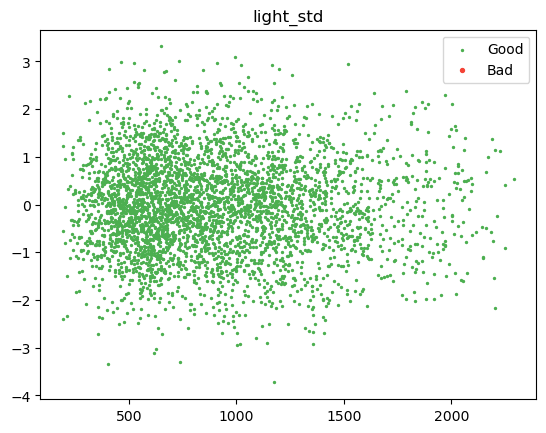

In [57]:
X,Y,group= plot_outliers(data=X,target=Y,group=group,df=X['light_std'],feature='light_std')
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)
group=group.reset_index(drop=True)

In [58]:
## remove no-contribution factotr
def perm_imp(model,data,target):
    X = data.to_numpy().copy()
    y = target.to_numpy().copy()
    permute = PermutationImportance(model,random_state=2023,n_iter =2,cv=10,scoring='neg_root_mean_squared_error').fit(X, y)
    eli5.show_weights(permute, feature_names = data.columns.tolist(),top=50)
    values = dict(zip(list(data.columns),list(permute.feature_importances_)))
    sorted_dict = {}
    sorted_keys = sorted(values, key=values.get)
    for w in sorted_keys:
        sorted_dict[w] = np.round(values[w],3)
    return sorted_dict

perm_imp(xgb.XGBRegressor(),X,Y)

{'Province_陕西省': -7272.538,
 'Province_甘肃省': -5615.248,
 'light_min': -5064.916,
 'Province_河北省': -393.704,
 'Province_北京市': 0.0,
 'Province_天津市': 0.0,
 'Province_海南省': 0.0,
 'Province_重庆市': 0.0,
 'Province_青海省': 0.0,
 'Province_nan': 0.0,
 'Province_新疆维吾尔自治区': 55.195,
 'Province_贵州省': 1469.692,
 'Province_安徽省': 2533.551,
 'Province_云南省': 4262.161,
 'Province_江苏省': 4391.494,
 'Province_吉林省': 4564.967,
 'Province_黑龙江省': 5211.16,
 'Province_宁夏回族自治区': 6571.037,
 'Province_广东省': 7927.093,
 'Province_福建省': 7928.31,
 'Province_江西省': 9096.15,
 'Province_辽宁省': 12471.593,
 'Province_河南省': 13737.51,
 'Province_浙江省': 17745.608,
 'Province_山东省': 21769.044,
 'Province_四川省': 22171.238,
 'Province_内蒙古自治区': 22348.717,
 'Province_广西壮族自治区': 32696.406,
 'PM_std': 40039.793,
 'PM_max': 49982.482,
 'Province_湖北省': 70159.425,
 'Province_山西省': 72272.717,
 'PM_min': 87927.051,
 'Province_湖南省': 106338.948,
 'PM_mean': 206502.944,
 'Second': 297839.67,
 'light_max': 376120.857,
 'PM_sum': 730083.677,
 'Third': 

In [59]:
drop_columns = ['PM_min','light_min']
X.drop(columns=drop_columns)

,population,First,Second,Third,light_mean,light_sum,light_max,light_std,PM_mean,PM_sum,...,Province_湖南省,Province_甘肃省,Province_福建省,Province_贵州省,Province_辽宁省,Province_重庆市,Province_陕西省,Province_青海省,Province_黑龙江省,Province_nan
0,607.89,19.10,42.27,38.63,291.559690,4396137.0,6030.0,603.245583,46.906599,5.864263e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,610.99,19.12,41.37,39.51,338.169335,4858817.0,6117.0,622.270181,53.054223,6.632839e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,613.89,19.05,42.44,38.52,347.235809,4997765.0,5834.0,599.247638,51.639594,6.455982e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,614.89,18.52,46.89,34.59,292.531081,4277682.0,5450.0,560.327760,49.854047,6.232753e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,615.75,15.74,53.03,31.23,342.196546,4834895.0,5359.0,514.517106,50.520133,6.316027e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865,782.80,14.27,45.92,39.81,164.962328,4956953.0,5197.0,426.648885,44.499399,1.258042e+06,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3866,790.19,16.11,44.77,39.12,198.132985,5160968.0,5397.0,456.474641,38.253189,1.081456e+06,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3867,798.00,15.41,44.22,40.37,194.865783,5599858.0,5448.0,457.481190,37.364108,1.056321e+06,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3868,804.00,0.00,0.00,0.00,159.082824,4863321.0,5312.0,456.503318,32.709639,9.247342e+05,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
#### Define the cv

########################
### General Settings ###
########################

gpu_switch = 'ON'

###############################
### RepeatedStratifiedKFold ###
###############################

n_splits = 5
n_repeats =10
cv_repeated = RepeatedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=2023)  ###repeated kfold
cv_group = GroupKFold(n_splits=n_splits)  ###group level fold: example,fold by city

### Step by step test

In [76]:
###############################################

def xgb_evaluation(period=0, show_stdv=True):
    # XGBoost 回调函数，用于定期输出评估结果
    def callback(env):
        if period > 0 and env.iteration % period == 0:
            result = env.evaluation_result_list[-1]  # 获取最新的评估结果
            if show_stdv:
                print(f"[{env.iteration}] {result[0]}-{result[1]}: {result[2]:.5f} ± {result[3]:.5f}")
            else:
                print(f"[{env.iteration}] {result[0]}-{result[1]}: {result[2]:.5f}")
    return callback


def mape(y,predt):
    mape = np.mean(np.abs((y - predt) / y)) * 100
    return mape

def model_test(model,X,y,cv=cv_repeated):
    results=[]


    for i,(train_index, test_index) in enumerate(cv.split(X, y)):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
        model = model.fit(train_X,train_y,
                        eval_set=[(valid_X,valid_y)],
                        ) 
        result= mape(y=valid_y,predt = model.predict(valid_X))
        results.append(result)
        print (f'\033[0;33;40m Step#{i} mape result = {result} \033[0;30;0m')
    print (f'\033[0;35;40m Final LGBM Result = {sum(results)/len(results)} \033[0;30;0m')

def model_test_group(model,X,y,group,cv=cv_group):
    results=[]

    for i,(train_index, test_index) in enumerate(cv.split(X, y,groups=group)):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
        model = model.fit(train_X,train_y,
                        eval_set=[(valid_X,valid_y)]) 
        result= mape(y=valid_y,predt = model.predict(valid_X))
        results.append(result)
        print (f'\033[0;33;40m Step#{i} mape result = {result} \033[0;30;0m')
    print (f'\033[0;35;40m Final LGBM Result = {sum(results)/len(results)} \033[0;30;0m')

In [77]:
xgboost_params = {
    'eta': 0.1, # 学习率
    'max_depth': 6, # 树的最大深度
    'subsample': 0.8, # 训练每棵树时样本的采样比率
    'colsample_bytree': 0.8, # 构建每棵树时特征的采样比率
    'n_estimators': 100, # 树的数量
    'min_child_weight': 1, # 决定最小叶子节点样本权重和
    'objective': 'reg:squarederror', # 回归任务的目标函数
    'eval_metric': 'rmse', # 评估指标，均方根误差
}

lightgbm_params = {
    'learning_rate': 0.1, # 学习率
    'max_depth': 6, # 树的最大深度，-1 表示无限制
    'num_leaves': 30, # 叶子的最大数量
    'feature_fraction': 0.8, # 在训练时用来进行特征采样的比例
    'bagging_fraction': 0.8, # 不进行放回的采样，类似于 XGBoost 的 subsample
    'num_iterations': 100, # 迭代次数
    'objective': 'regression', # 回归任务
    'metric': 'rmse', # 评估指标，均方根误差
}

xgb_model = xgb.XGBRegressor(**xgboost_params) 
lgb_model = lgb.LGBMRegressor(**lightgbm_params)


In [ ]:
model_test(model=xgb_model,X=X,y=Y,cv=cv_repeated)

In [70]:
model_test_group(model=xgb_model,X=X,y=Y,group=group,cv=cv_group)

[0]	validation_0-rmse:22909607.40546
[1]	validation_0-rmse:21551101.94473
[2]	validation_0-rmse:19866360.20727
[3]	validation_0-rmse:18575725.39013
[4]	validation_0-rmse:17196801.71163
[5]	validation_0-rmse:16192403.92166
[6]	validation_0-rmse:15242178.25918
[7]	validation_0-rmse:14645726.37656
[8]	validation_0-rmse:13988110.10897
[9]	validation_0-rmse:13403837.53087
[10]	validation_0-rmse:12911187.39109
[11]	validation_0-rmse:12382099.13327
[12]	validation_0-rmse:11893152.91216
[13]	validation_0-rmse:11495840.62193
[14]	validation_0-rmse:11146116.74795
[15]	validation_0-rmse:10878758.66350
[16]	validation_0-rmse:10645662.10778
[17]	validation_0-rmse:10511344.22229
[18]	validation_0-rmse:10284378.91596
[19]	validation_0-rmse:10213055.69255
[20]	validation_0-rmse:10107657.10321
[21]	validation_0-rmse:9927084.69277
[22]	validation_0-rmse:9843095.54594
[23]	validation_0-rmse:9796139.62016
[24]	validation_0-rmse:9777485.69424
[25]	validation_0-rmse:9739158.03656
[26]	validation_0-rmse:9707

d:\Anaconda\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[64]	validation_0-rmse:9354057.30596
[65]	validation_0-rmse:9354528.33787
[66]	validation_0-rmse:9357232.25691
 Step#0 mape result = 38.66081414905675 
[0]	validation_0-rmse:29067665.37692
[1]	validation_0-rmse:27474510.75737
[2]	validation_0-rmse:25646202.05067
[3]	validation_0-rmse:23906140.10001
[4]	validation_0-rmse:22353649.99587
[5]	validation_0-rmse:20884567.22184
[6]	validation_0-rmse:19634214.00485
[7]	validation_0-rmse:18875616.49180
[8]	validation_0-rmse:18201967.64084
[9]	validation_0-rmse:17639172.38789
[10]	validation_0-rmse:17132424.39071
[11]	validation_0-rmse:16472879.53336
[12]	validation_0-rmse:15797269.65870
[13]	validation_0-rmse:15334203.52385
[14]	validation_0-rmse:15096096.42387
[15]	validation_0-rmse:14750242.33827
[16]	validation_0-rmse:14484141.30242
[17]	validation_0-rmse:14184309.50866
[18]	validation_0-rmse:13914583.75228
[19]	validation_0-rmse:13827459.89934
[20]	validation_0-rmse:13719301.64822
[21]	validation_0-rmse:13582358.76214
[22]	validation_0-rmse

In [78]:
model_test(model=lgb_model,X=X,y=Y,cv=cv_repeated)

d:\Anaconda\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 3096, number of used features: 39
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fr

In [79]:
model_test_group(model=lgb_model,X=X,y=Y,group=group,cv=cv_group)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3401
[LightGBM] [Info] Number of data points in the train set: 3097, number of used features: 39
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fr

d:\Anaconda\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [90]:
#### 调参
from tqdm.auto import tqdm

def objective_xgboost(trial):
    param = {  
        'tree_method': 'hist',
        'device': 'cuda',
        #'objective': objective,
        #'eval_metric': 'auc',
        'lambda': trial.suggest_float('lambda', 0, 10.0),
        'alpha': trial.suggest_float('alpha', 0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1.0),
        'subsample': trial.suggest_float('subsample', 0.5,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100,700),
        'max_depth': trial.suggest_categorical('max_depth', [3,4,5,6,7,8,9,10,11,12,13]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree',1,1),
        'early_stopping_rounds':trial.suggest_int('early_stopping_rounds',200,200),
        #'scale_pos_weight':weight[0],
        }
    results=[]
    n_iterations=[]  
    for train_index, test_index in cv_repeated.split(X, Y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = Y.iloc[train_index], Y.iloc[test_index]
        model = xgb.XGBRegressor(**param).fit(train_X,train_y,
                                      eval_set=[(valid_X,valid_y)],
                                      verbose=0,
     
                                     )  
        result =  mape(y=valid_y,predt=model.predict(valid_X))
        results.append(result)
    n=sum(results)/len(results)
    print('finished')
    return n

def callback(study, trial):
    pbar.update(1)

n_trials = 100
study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='minimize')
pbar = tqdm(total=n_trials, desc="Optuna Study")

study.optimize(objective_xgboost, n_trials=n_trials,callbacks=[callback])

pbar.close()

print('Best trial:', study.best_trial.params)

[I 2024-03-09 14:27:35,266] A new study created in memory with name: no-name-ba65b211-9416-4a62-9d6f-937cb4aea51f


Optuna Study:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-03-09 14:31:14,793] Trial 0 finished with value: 25.482923840692237 and parameters: {'lambda': 7.916291827305194, 'alpha': 2.643291620202125, 'colsample_bytree': 0.4273610719648717, 'subsample': 0.5634478730693256, 'learning_rate': 0.09256875011043142, 'n_estimators': 669, 'max_depth': 12, 'min_child_weight': 5, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 0 with value: 25.482923840692237.


finished


[I 2024-03-09 14:32:45,017] Trial 1 finished with value: 25.095413596577394 and parameters: {'lambda': 3.654416101745549, 'alpha': 1.6408201167178582, 'colsample_bytree': 0.8175079715852668, 'subsample': 0.8594321291780658, 'learning_rate': 0.05851063191162083, 'n_estimators': 473, 'max_depth': 6, 'min_child_weight': 10, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 1 with value: 25.095413596577394.


finished


[I 2024-03-09 14:33:39,012] Trial 2 finished with value: 33.18843601376638 and parameters: {'lambda': 5.807941365598154, 'alpha': 0.4410890244089505, 'colsample_bytree': 0.9667684271827526, 'subsample': 0.8086804605735048, 'learning_rate': 0.06680451454430766, 'n_estimators': 361, 'max_depth': 3, 'min_child_weight': 6, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 1 with value: 25.095413596577394.


finished


[I 2024-03-09 14:35:15,668] Trial 3 finished with value: 29.644280725239852 and parameters: {'lambda': 6.228394491335094, 'alpha': 2.9654841061522577, 'colsample_bytree': 0.3857459281441199, 'subsample': 0.5247048829138494, 'learning_rate': 0.026148464092987114, 'n_estimators': 438, 'max_depth': 7, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 1 with value: 25.095413596577394.


finished


[I 2024-03-09 14:36:00,860] Trial 4 finished with value: 27.002241681469556 and parameters: {'lambda': 3.7812166383039028, 'alpha': 5.67406523943119, 'colsample_bytree': 0.8669817515215174, 'subsample': 0.9670013555128432, 'learning_rate': 0.06476763639087736, 'n_estimators': 251, 'max_depth': 5, 'min_child_weight': 5, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 1 with value: 25.095413596577394.


finished


[I 2024-03-09 14:36:24,423] Trial 5 finished with value: 37.13585507955142 and parameters: {'lambda': 2.7280998305271353, 'alpha': 4.851794124654614, 'colsample_bytree': 0.9571531141752899, 'subsample': 0.873750751951671, 'learning_rate': 0.07509601538988524, 'n_estimators': 148, 'max_depth': 3, 'min_child_weight': 5, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 1 with value: 25.095413596577394.


finished


[I 2024-03-09 14:39:34,600] Trial 6 finished with value: 23.981847864777116 and parameters: {'lambda': 5.903754101629178, 'alpha': 9.716753038602366, 'colsample_bytree': 0.4859722602509323, 'subsample': 0.7767825088353553, 'learning_rate': 0.06249740367210589, 'n_estimators': 585, 'max_depth': 12, 'min_child_weight': 7, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 6 with value: 23.981847864777116.


finished


[I 2024-03-09 14:40:44,882] Trial 7 finished with value: 25.90111426324053 and parameters: {'lambda': 5.623342645507931, 'alpha': 4.649907195412828, 'colsample_bytree': 0.4459251782529573, 'subsample': 0.6612296317366995, 'learning_rate': 0.061930630078569554, 'n_estimators': 261, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 6 with value: 23.981847864777116.


finished


[I 2024-03-09 14:43:09,271] Trial 8 finished with value: 21.147197795641947 and parameters: {'lambda': 0.0033113718895194655, 'alpha': 8.84624772862596, 'colsample_bytree': 0.9368114442424238, 'subsample': 0.7853712316415014, 'learning_rate': 0.0874491785317481, 'n_estimators': 452, 'max_depth': 12, 'min_child_weight': 6, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 14:44:14,636] Trial 9 finished with value: 25.013767450291997 and parameters: {'lambda': 6.8076190439604485, 'alpha': 5.3540998343289194, 'colsample_bytree': 0.6524199067491385, 'subsample': 0.6178942648971091, 'learning_rate': 0.05068074991971558, 'n_estimators': 210, 'max_depth': 10, 'min_child_weight': 4, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 14:45:45,905] Trial 10 finished with value: 34.243698679561504 and parameters: {'lambda': 0.1352509321671987, 'alpha': 9.125197864147923, 'colsample_bytree': 0.2220450066825938, 'subsample': 0.6875216706084811, 'learning_rate': 0.0979694607276332, 'n_estimators': 547, 'max_depth': 4, 'min_child_weight': 9, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 14:49:03,985] Trial 11 finished with value: 22.375797987541517 and parameters: {'lambda': 0.06945053597059261, 'alpha': 9.978081024897254, 'colsample_bytree': 0.6406620817799845, 'subsample': 0.7513542598315565, 'learning_rate': 0.038850926894095604, 'n_estimators': 616, 'max_depth': 12, 'min_child_weight': 8, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 14:52:55,882] Trial 12 finished with value: 22.415719091440714 and parameters: {'lambda': 0.43353844032745587, 'alpha': 7.546121377110759, 'colsample_bytree': 0.6552936458896267, 'subsample': 0.7286568326773812, 'learning_rate': 0.034142605637320224, 'n_estimators': 676, 'max_depth': 13, 'min_child_weight': 8, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 14:55:02,883] Trial 13 finished with value: 26.851391739550525 and parameters: {'lambda': 1.7116743217423742, 'alpha': 7.649151848498811, 'colsample_bytree': 0.7185970267855126, 'subsample': 0.9380266410401897, 'learning_rate': 0.012308093835875188, 'n_estimators': 351, 'max_depth': 9, 'min_child_weight': 3, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 14:57:39,778] Trial 14 finished with value: 48.681462328575314 and parameters: {'lambda': 9.724158580615338, 'alpha': 8.27093500076606, 'colsample_bytree': 0.1004855467943171, 'subsample': 0.8172502821577526, 'learning_rate': 0.04299409090135282, 'n_estimators': 550, 'max_depth': 12, 'min_child_weight': 7, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 14:59:58,929] Trial 15 finished with value: 22.159026515682495 and parameters: {'lambda': 1.3043563793076873, 'alpha': 9.827493954347567, 'colsample_bytree': 0.7772986853832189, 'subsample': 0.720613622820311, 'learning_rate': 0.08350105994309015, 'n_estimators': 483, 'max_depth': 11, 'min_child_weight': 8, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 15:02:32,416] Trial 16 finished with value: 22.32150728834886 and parameters: {'lambda': 1.7237594221636598, 'alpha': 6.788592927686899, 'colsample_bytree': 0.858102951334733, 'subsample': 0.6944180375709593, 'learning_rate': 0.08385929400487874, 'n_estimators': 475, 'max_depth': 13, 'min_child_weight': 10, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 15:04:54,518] Trial 17 finished with value: 21.791234960082356 and parameters: {'lambda': 1.8968945328625948, 'alpha': 8.617167078048134, 'colsample_bytree': 0.7622495600470582, 'subsample': 0.6138737516628476, 'learning_rate': 0.0824950178078535, 'n_estimators': 398, 'max_depth': 11, 'min_child_weight': 3, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 15:06:58,482] Trial 18 finished with value: 21.425004599979435 and parameters: {'lambda': 4.158549871530896, 'alpha': 6.367866703567088, 'colsample_bytree': 0.992306905953681, 'subsample': 0.5969208306029938, 'learning_rate': 0.07972341326912082, 'n_estimators': 352, 'max_depth': 11, 'min_child_weight': 3, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 15:08:49,232] Trial 19 finished with value: 21.605432876212504 and parameters: {'lambda': 4.303619298158148, 'alpha': 6.446852734402984, 'colsample_bytree': 0.98547873285904, 'subsample': 0.6255405406682231, 'learning_rate': 0.07718255406094256, 'n_estimators': 310, 'max_depth': 11, 'min_child_weight': 3, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 15:09:18,082] Trial 20 finished with value: 30.488304570556394 and parameters: {'lambda': 7.734312950810363, 'alpha': 4.028089585634523, 'colsample_bytree': 0.8983893247147857, 'subsample': 0.5236142762503835, 'learning_rate': 0.09187897486269407, 'n_estimators': 156, 'max_depth': 5, 'min_child_weight': 4, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 15:11:20,395] Trial 21 finished with value: 21.54716195596642 and parameters: {'lambda': 4.4117086473142475, 'alpha': 6.646086623851299, 'colsample_bytree': 0.987170907655216, 'subsample': 0.6194343278681677, 'learning_rate': 0.07464396294653773, 'n_estimators': 315, 'max_depth': 11, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 15:13:10,857] Trial 22 finished with value: 21.69553051880834 and parameters: {'lambda': 4.859423006944085, 'alpha': 6.535189692759627, 'colsample_bytree': 0.9961804201355774, 'subsample': 0.5700396504013335, 'learning_rate': 0.07369647126257718, 'n_estimators': 293, 'max_depth': 11, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 15:15:36,222] Trial 23 finished with value: 21.291211309954114 and parameters: {'lambda': 2.887827027792234, 'alpha': 7.49172756160336, 'colsample_bytree': 0.9154709845963557, 'subsample': 0.5730091193898075, 'learning_rate': 0.08922794650227447, 'n_estimators': 386, 'max_depth': 11, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 8 with value: 21.147197795641947.


finished


[I 2024-03-09 15:17:40,470] Trial 24 finished with value: 21.11944852151547 and parameters: {'lambda': 3.1612313301151813, 'alpha': 8.266160714109656, 'colsample_bytree': 0.8992160504513473, 'subsample': 0.5776834163054895, 'learning_rate': 0.09683839353087667, 'n_estimators': 410, 'max_depth': 9, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 24 with value: 21.11944852151547.


finished


[I 2024-03-09 15:19:38,348] Trial 25 finished with value: 21.50455993857289 and parameters: {'lambda': 2.795170934644677, 'alpha': 7.800670358043228, 'colsample_bytree': 0.8971697690773133, 'subsample': 0.5040322973695344, 'learning_rate': 0.09954738026351975, 'n_estimators': 396, 'max_depth': 9, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 24 with value: 21.11944852151547.


finished


[I 2024-03-09 15:21:30,133] Trial 26 finished with value: 23.50271792001183 and parameters: {'lambda': 2.851477607758457, 'alpha': 8.588269614015509, 'colsample_bytree': 0.57243138558748, 'subsample': 0.6782231057914466, 'learning_rate': 0.0902950342739344, 'n_estimators': 437, 'max_depth': 9, 'min_child_weight': 6, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 24 with value: 21.11944852151547.


finished


[I 2024-03-09 15:23:09,097] Trial 27 finished with value: 22.895218476414797 and parameters: {'lambda': 0.9594773970773022, 'alpha': 9.047979156593033, 'colsample_bytree': 0.7408129516233365, 'subsample': 0.5619865371857165, 'learning_rate': 0.08982393655205384, 'n_estimators': 519, 'max_depth': 6, 'min_child_weight': 4, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 24 with value: 21.11944852151547.


finished


[I 2024-03-09 15:26:26,465] Trial 28 finished with value: 21.000850677965822 and parameters: {'lambda': 3.233430442799005, 'alpha': 7.603505864466399, 'colsample_bytree': 0.8386736784722439, 'subsample': 0.8565418540924616, 'learning_rate': 0.0994973632333225, 'n_estimators': 433, 'max_depth': 10, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 28 with value: 21.000850677965822.


finished


[I 2024-03-09 15:29:35,534] Trial 29 finished with value: 29.23909349768988 and parameters: {'lambda': 2.2446262584355, 'alpha': 9.13027653427294, 'colsample_bytree': 0.3222036152826069, 'subsample': 0.9060603496009273, 'learning_rate': 0.09934942313534795, 'n_estimators': 431, 'max_depth': 10, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 28 with value: 21.000850677965822.


finished


[I 2024-03-09 15:31:58,964] Trial 30 finished with value: 21.732003114948512 and parameters: {'lambda': 9.088517638918077, 'alpha': 8.181128746872396, 'colsample_bytree': 0.8180170543520336, 'subsample': 0.8373469445699767, 'learning_rate': 0.09605304514784532, 'n_estimators': 507, 'max_depth': 10, 'min_child_weight': 6, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 28 with value: 21.000850677965822.


finished


[I 2024-03-09 15:34:34,390] Trial 31 finished with value: 20.677733220773558 and parameters: {'lambda': 3.0704519922617326, 'alpha': 7.153185959369377, 'colsample_bytree': 0.9104282905501278, 'subsample': 0.7786810839119144, 'learning_rate': 0.08792385544965876, 'n_estimators': 381, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 31 with value: 20.677733220773558.


finished


[I 2024-03-09 15:38:41,316] Trial 32 finished with value: 20.924830583722112 and parameters: {'lambda': 3.509901959893473, 'alpha': 7.215353094633007, 'colsample_bytree': 0.8363004164246286, 'subsample': 0.7839164636170095, 'learning_rate': 0.08655569917769913, 'n_estimators': 431, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 31 with value: 20.677733220773558.


finished


[I 2024-03-09 15:42:15,883] Trial 33 finished with value: 21.16393039380557 and parameters: {'lambda': 3.2924884564322503, 'alpha': 7.208597029391587, 'colsample_bytree': 0.8033282783556916, 'subsample': 0.8635758620160316, 'learning_rate': 0.06986584289379688, 'n_estimators': 369, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 31 with value: 20.677733220773558.


finished


[I 2024-03-09 15:46:35,123] Trial 34 finished with value: 20.92901189928499 and parameters: {'lambda': 3.4526270131879944, 'alpha': 5.812617749888572, 'colsample_bytree': 0.8343008606887006, 'subsample': 0.7797123800154984, 'learning_rate': 0.09442603366728604, 'n_estimators': 418, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 31 with value: 20.677733220773558.


finished


[I 2024-03-09 15:49:48,373] Trial 35 finished with value: 22.684341914215317 and parameters: {'lambda': 5.161033249169289, 'alpha': 5.959934858457229, 'colsample_bytree': 0.7130939761965125, 'subsample': 0.7815673987189651, 'learning_rate': 0.0538428330212851, 'n_estimators': 335, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 31 with value: 20.677733220773558.


finished


[I 2024-03-09 15:53:55,995] Trial 36 finished with value: 20.848454383166267 and parameters: {'lambda': 3.9164216004858283, 'alpha': 3.8813473286850204, 'colsample_bytree': 0.8382526761685937, 'subsample': 0.8277374360190372, 'learning_rate': 0.09374668810881413, 'n_estimators': 506, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 31 with value: 20.677733220773558.


finished


[I 2024-03-09 15:56:34,062] Trial 37 finished with value: 22.073687828901505 and parameters: {'lambda': 3.799774768053223, 'alpha': 3.1311196236356937, 'colsample_bytree': 0.5860756905601755, 'subsample': 0.8071127654365327, 'learning_rate': 0.08582616935189431, 'n_estimators': 592, 'max_depth': 8, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 31 with value: 20.677733220773558.


finished


[I 2024-03-09 15:59:35,976] Trial 38 finished with value: 20.70533091906057 and parameters: {'lambda': 5.027341122593864, 'alpha': 1.814130888160041, 'colsample_bytree': 0.8463195483740998, 'subsample': 0.7575680326601782, 'learning_rate': 0.093767538997826, 'n_estimators': 630, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 31 with value: 20.677733220773558.


finished


[I 2024-03-09 16:02:41,965] Trial 39 finished with value: 21.089239736220296 and parameters: {'lambda': 5.102342645964749, 'alpha': 1.1098866407942918, 'colsample_bytree': 0.7073908031388407, 'subsample': 0.8933570876407053, 'learning_rate': 0.08175240627705757, 'n_estimators': 646, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 31 with value: 20.677733220773558.


finished


[I 2024-03-09 16:05:04,661] Trial 40 finished with value: 21.16664671367079 and parameters: {'lambda': 6.662568815760338, 'alpha': 1.9942886578526855, 'colsample_bytree': 0.7793198690975436, 'subsample': 0.7523212552092217, 'learning_rate': 0.07088639202582281, 'n_estimators': 636, 'max_depth': 7, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 31 with value: 20.677733220773558.


finished


[I 2024-03-09 16:07:33,941] Trial 41 finished with value: 20.747121010027385 and parameters: {'lambda': 3.684772447858473, 'alpha': 3.8558680320611183, 'colsample_bytree': 0.8528756914058453, 'subsample': 0.8219593042488136, 'learning_rate': 0.09349476262934482, 'n_estimators': 511, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 31 with value: 20.677733220773558.


finished


[I 2024-03-09 16:10:09,521] Trial 42 finished with value: 20.58080834986746 and parameters: {'lambda': 3.885465484645091, 'alpha': 3.964977588977361, 'colsample_bytree': 0.9359115038772673, 'subsample': 0.8245247517097738, 'learning_rate': 0.09316971059886474, 'n_estimators': 530, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 42 with value: 20.58080834986746.


finished


[I 2024-03-09 16:12:49,880] Trial 43 finished with value: 20.502140211195364 and parameters: {'lambda': 4.543269672900066, 'alpha': 3.7091159496720048, 'colsample_bytree': 0.9392972821366942, 'subsample': 0.8286690266170563, 'learning_rate': 0.09338918083206198, 'n_estimators': 548, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 43 with value: 20.502140211195364.


finished


[I 2024-03-09 16:14:12,042] Trial 44 finished with value: 29.073596796588504 and parameters: {'lambda': 4.7953598180070545, 'alpha': 0.028089456109801958, 'colsample_bytree': 0.9454801399156405, 'subsample': 0.8422668407142467, 'learning_rate': 0.09120138053872792, 'n_estimators': 562, 'max_depth': 3, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 43 with value: 20.502140211195364.


finished


[I 2024-03-09 16:16:39,975] Trial 45 finished with value: 20.889037097431498 and parameters: {'lambda': 5.608711104821355, 'alpha': 2.695049046208516, 'colsample_bytree': 0.8782030194583177, 'subsample': 0.7289809093765274, 'learning_rate': 0.07791301431777341, 'n_estimators': 586, 'max_depth': 8, 'min_child_weight': 3, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 43 with value: 20.502140211195364.


finished


[I 2024-03-09 16:20:04,566] Trial 46 finished with value: 20.470934908399336 and parameters: {'lambda': 6.291733905164438, 'alpha': 3.535664297854747, 'colsample_bytree': 0.9512683810197978, 'subsample': 0.8041579012177191, 'learning_rate': 0.09425758262841065, 'n_estimators': 692, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 16:21:58,831] Trial 47 finished with value: 24.393928882703502 and parameters: {'lambda': 5.882645834905452, 'alpha': 4.470672900064569, 'colsample_bytree': 0.9373297343123121, 'subsample': 0.9980869533932506, 'learning_rate': 0.08667416153678068, 'n_estimators': 699, 'max_depth': 4, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 16:24:54,173] Trial 48 finished with value: 20.606941406963323 and parameters: {'lambda': 7.353695849411295, 'alpha': 2.01031649775475, 'colsample_bytree': 0.9512902205275381, 'subsample': 0.7574962036205327, 'learning_rate': 0.09452797596538906, 'n_estimators': 617, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 16:27:39,367] Trial 49 finished with value: 25.95981587917374 and parameters: {'lambda': 7.600796265671947, 'alpha': 3.3435348254139927, 'colsample_bytree': 0.94773187974498, 'subsample': 0.7980757204745138, 'learning_rate': 0.012509540927701075, 'n_estimators': 668, 'max_depth': 8, 'min_child_weight': 3, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 16:29:36,540] Trial 50 finished with value: 22.079015381666583 and parameters: {'lambda': 7.112100720076274, 'alpha': 2.10001241873167, 'colsample_bytree': 0.9526216902650549, 'subsample': 0.893771423571431, 'learning_rate': 0.05980618276036842, 'n_estimators': 611, 'max_depth': 6, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 16:32:55,371] Trial 51 finished with value: 20.649916431295132 and parameters: {'lambda': 8.312200120886036, 'alpha': 1.2150347173877565, 'colsample_bytree': 0.917198205672552, 'subsample': 0.759205577223094, 'learning_rate': 0.0953685298184711, 'n_estimators': 698, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 16:36:16,864] Trial 52 finished with value: 20.511417791279555 and parameters: {'lambda': 6.237855312591268, 'alpha': 0.8809805447043363, 'colsample_bytree': 0.9090111710974449, 'subsample': 0.7104386593138554, 'learning_rate': 0.0961699003373637, 'n_estimators': 699, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 16:39:00,711] Trial 53 finished with value: 20.821198361552902 and parameters: {'lambda': 8.554654283552932, 'alpha': 1.1264828983483222, 'colsample_bytree': 0.9252370277327655, 'subsample': 0.7166872403223251, 'learning_rate': 0.09662087043244197, 'n_estimators': 700, 'max_depth': 7, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 16:40:55,128] Trial 54 finished with value: 22.65187572188661 and parameters: {'lambda': 8.329950365955213, 'alpha': 0.8168223936475426, 'colsample_bytree': 0.8754782647842244, 'subsample': 0.760214383765658, 'learning_rate': 0.08081578523967171, 'n_estimators': 669, 'max_depth': 5, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 16:43:45,047] Trial 55 finished with value: 22.884103007270667 and parameters: {'lambda': 6.218159369076353, 'alpha': 2.4673393711949694, 'colsample_bytree': 0.9668670355555259, 'subsample': 0.7096431600835241, 'learning_rate': 0.025379172053839424, 'n_estimators': 657, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 16:47:29,669] Trial 56 finished with value: 26.508713432933995 and parameters: {'lambda': 7.06362596458994, 'alpha': 3.3596726031939306, 'colsample_bytree': 0.386208702202141, 'subsample': 0.8070564171635143, 'learning_rate': 0.09141570945350606, 'n_estimators': 567, 'max_depth': 13, 'min_child_weight': 4, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 16:48:57,985] Trial 57 finished with value: 30.225809165526094 and parameters: {'lambda': 6.57738786390966, 'alpha': 1.4255402709777703, 'colsample_bytree': 0.797477489836384, 'subsample': 0.6658103818137668, 'learning_rate': 0.08424888934270947, 'n_estimators': 605, 'max_depth': 3, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 16:51:46,688] Trial 58 finished with value: 22.918641132602737 and parameters: {'lambda': 7.31162893892183, 'alpha': 5.145844840929281, 'colsample_bytree': 0.5069027156350321, 'subsample': 0.7354451684293197, 'learning_rate': 0.09609311185927266, 'n_estimators': 685, 'max_depth': 8, 'min_child_weight': 3, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 16:54:33,975] Trial 59 finished with value: 21.265266546122316 and parameters: {'lambda': 8.280062705114952, 'alpha': 0.6404524038692053, 'colsample_bytree': 0.876564873497874, 'subsample': 0.6950712922577597, 'learning_rate': 0.04878180217860235, 'n_estimators': 638, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 16:56:00,421] Trial 60 finished with value: 26.040285015256117 and parameters: {'lambda': 6.289565579513674, 'alpha': 4.307552871609493, 'colsample_bytree': 0.99767494952839, 'subsample': 0.646167402707763, 'learning_rate': 0.08823579648209479, 'n_estimators': 531, 'max_depth': 4, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 16:59:02,599] Trial 61 finished with value: 20.75467906360295 and parameters: {'lambda': 9.066933675959573, 'alpha': 2.375375974423684, 'colsample_bytree': 0.9147465316735827, 'subsample': 0.7376846634311313, 'learning_rate': 0.0997303377604093, 'n_estimators': 653, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:01:15,700] Trial 62 finished with value: 20.54320502410969 and parameters: {'lambda': 4.570860695572171, 'alpha': 1.3758964690396347, 'colsample_bytree': 0.9566351163386781, 'subsample': 0.7637357907334634, 'learning_rate': 0.08797427293186892, 'n_estimators': 460, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:05:06,016] Trial 63 finished with value: 21.181729117500904 and parameters: {'lambda': 4.388159402101001, 'alpha': 0.24606260381421108, 'colsample_bytree': 0.9681329064798653, 'subsample': 0.7653511616743918, 'learning_rate': 0.09297139178328352, 'n_estimators': 458, 'max_depth': 12, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:07:33,825] Trial 64 finished with value: 20.625148096661118 and parameters: {'lambda': 5.490311556521848, 'alpha': 1.538470815892393, 'colsample_bytree': 0.9686136267697043, 'subsample': 0.7999309708900335, 'learning_rate': 0.09698899167149212, 'n_estimators': 537, 'max_depth': 8, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:10:01,371] Trial 65 finished with value: 20.610749242679095 and parameters: {'lambda': 5.459827418343693, 'alpha': 1.5621716051616945, 'colsample_bytree': 0.971645790249064, 'subsample': 0.8014573126674965, 'learning_rate': 0.09097752979113169, 'n_estimators': 536, 'max_depth': 8, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:12:21,603] Trial 66 finished with value: 20.620531596001005 and parameters: {'lambda': 5.399709230426499, 'alpha': 3.034737072316747, 'colsample_bytree': 0.881488052556015, 'subsample': 0.8518130905143761, 'learning_rate': 0.08405481315920818, 'n_estimators': 488, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:13:56,555] Trial 67 finished with value: 23.40169739791889 and parameters: {'lambda': 4.682021738550674, 'alpha': 2.69345902231411, 'colsample_bytree': 0.9373370138527481, 'subsample': 0.8302745969383799, 'learning_rate': 0.07976156481324113, 'n_estimators': 554, 'max_depth': 5, 'min_child_weight': 5, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:15:45,529] Trial 68 finished with value: 37.51368799056076 and parameters: {'lambda': 6.299593377730028, 'alpha': 3.503049188188886, 'colsample_bytree': 0.1241425074210385, 'subsample': 0.8749963029605063, 'learning_rate': 0.08882134719954146, 'n_estimators': 579, 'max_depth': 6, 'min_child_weight': 7, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:20:23,714] Trial 69 finished with value: 21.23432195361522 and parameters: {'lambda': 4.086841755613219, 'alpha': 0.6925779230625302, 'colsample_bytree': 0.9994908141238631, 'subsample': 0.9319001466712161, 'learning_rate': 0.09011148282504576, 'n_estimators': 617, 'max_depth': 13, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:22:13,632] Trial 70 finished with value: 22.73986074463548 and parameters: {'lambda': 5.994230281204116, 'alpha': 4.775869017362146, 'colsample_bytree': 0.9725217027008717, 'subsample': 0.7914556695471634, 'learning_rate': 0.07750632156167513, 'n_estimators': 491, 'max_depth': 8, 'min_child_weight': 10, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:24:28,028] Trial 71 finished with value: 20.789402434607656 and parameters: {'lambda': 5.388622967696761, 'alpha': 2.2248492909816386, 'colsample_bytree': 0.8675194705845887, 'subsample': 0.8548339550475815, 'learning_rate': 0.08456283534022933, 'n_estimators': 458, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:26:47,533] Trial 72 finished with value: 20.625331470279757 and parameters: {'lambda': 4.56934871953182, 'alpha': 3.0596918928115384, 'colsample_bytree': 0.8872190688238468, 'subsample': 0.8485487840158247, 'learning_rate': 0.09179906646667188, 'n_estimators': 471, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:29:22,171] Trial 73 finished with value: 20.512724422668892 and parameters: {'lambda': 5.755250095553324, 'alpha': 3.5985645442485934, 'colsample_bytree': 0.9094495306384283, 'subsample': 0.809676860705324, 'learning_rate': 0.0861414047316909, 'n_estimators': 526, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:31:59,155] Trial 74 finished with value: 20.64020557429109 and parameters: {'lambda': 5.99243101476989, 'alpha': 3.6171855683888743, 'colsample_bytree': 0.9294655600010657, 'subsample': 0.821055857304178, 'learning_rate': 0.08809301866505932, 'n_estimators': 533, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:34:47,931] Trial 75 finished with value: 20.575362800937228 and parameters: {'lambda': 5.176414401275108, 'alpha': 4.150159211562158, 'colsample_bytree': 0.9040196618689265, 'subsample': 0.7442013403433736, 'learning_rate': 0.0980163421102133, 'n_estimators': 599, 'max_depth': 8, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:37:38,488] Trial 76 finished with value: 20.91485254056649 and parameters: {'lambda': 6.910306073991931, 'alpha': 4.240159078754784, 'colsample_bytree': 0.8192440539792545, 'subsample': 0.7001025202752702, 'learning_rate': 0.0971509018682225, 'n_estimators': 597, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:41:11,182] Trial 77 finished with value: 21.074037256983303 and parameters: {'lambda': 6.464289256402622, 'alpha': 5.0153138703680025, 'colsample_bytree': 0.9033218374274391, 'subsample': 0.7425901529241209, 'learning_rate': 0.09955968145683901, 'n_estimators': 577, 'max_depth': 12, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:43:40,379] Trial 78 finished with value: 20.666080604098397 and parameters: {'lambda': 5.215925086669305, 'alpha': 5.498394979797002, 'colsample_bytree': 0.9502836225080218, 'subsample': 0.7698187569907813, 'learning_rate': 0.09395208358185847, 'n_estimators': 622, 'max_depth': 7, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 46 with value: 20.470934908399336.


finished


[I 2024-03-09 17:47:53,496] Trial 79 finished with value: 20.343220939650497 and parameters: {'lambda': 5.7462610449986045, 'alpha': 4.052949525951977, 'colsample_bytree': 0.9071822816728665, 'subsample': 0.8707435208911991, 'learning_rate': 0.08617279144435476, 'n_estimators': 681, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 79 with value: 20.343220939650497.


finished


[I 2024-03-09 17:51:19,537] Trial 80 finished with value: 21.29243801180423 and parameters: {'lambda': 2.3935744077188463, 'alpha': 4.075729613353576, 'colsample_bytree': 0.677116368574729, 'subsample': 0.8769639814935035, 'learning_rate': 0.08633046070094823, 'n_estimators': 686, 'max_depth': 9, 'min_child_weight': 3, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 79 with value: 20.343220939650497.


finished


[I 2024-03-09 17:55:22,031] Trial 81 finished with value: 20.4556119930067 and parameters: {'lambda': 5.749126735885336, 'alpha': 3.7064923330250954, 'colsample_bytree': 0.9069855684520326, 'subsample': 0.8148180465129158, 'learning_rate': 0.09766273095106247, 'n_estimators': 664, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 79 with value: 20.343220939650497.


finished


[I 2024-03-09 17:59:23,955] Trial 82 finished with value: 20.49573389375455 and parameters: {'lambda': 5.768760347795567, 'alpha': 3.65560249115558, 'colsample_bytree': 0.9034785160169687, 'subsample': 0.8170717252036277, 'learning_rate': 0.09781202839119721, 'n_estimators': 666, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 79 with value: 20.343220939650497.


finished


[I 2024-03-09 18:02:52,656] Trial 83 finished with value: 21.230707450624795 and parameters: {'lambda': 5.6490362832165575, 'alpha': 4.531333324140171, 'colsample_bytree': 0.7584594780942335, 'subsample': 0.8373162939996721, 'learning_rate': 0.09732019086358343, 'n_estimators': 663, 'max_depth': 9, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 79 with value: 20.343220939650497.


finished


[I 2024-03-09 18:06:49,991] Trial 84 finished with value: 20.28482825109008 and parameters: {'lambda': 5.8392695493435705, 'alpha': 3.6433222416522324, 'colsample_bytree': 0.900664136709699, 'subsample': 0.8137747057596008, 'learning_rate': 0.06707928888439833, 'n_estimators': 679, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 84 with value: 20.28482825109008.


finished


[I 2024-03-09 18:09:34,340] Trial 85 finished with value: 21.696329902390886 and parameters: {'lambda': 5.851640807039166, 'alpha': 3.708855004544704, 'colsample_bytree': 0.8593103877006354, 'subsample': 0.8145169587914198, 'learning_rate': 0.07336415902592029, 'n_estimators': 684, 'max_depth': 9, 'min_child_weight': 9, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 84 with value: 20.28482825109008.


finished


[I 2024-03-09 18:13:15,218] Trial 86 finished with value: 20.75586240937313 and parameters: {'lambda': 6.765778488938684, 'alpha': 2.78955150664018, 'colsample_bytree': 0.8134522411747078, 'subsample': 0.8632825025156798, 'learning_rate': 0.06886162591419759, 'n_estimators': 646, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 84 with value: 20.28482825109008.


finished


[I 2024-03-09 18:17:09,690] Trial 87 finished with value: 20.26007317265411 and parameters: {'lambda': 4.877467867304703, 'alpha': 3.2089737121632593, 'colsample_bytree': 0.8935284188178969, 'subsample': 0.7877600811387854, 'learning_rate': 0.06529635237864326, 'n_estimators': 663, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 87 with value: 20.26007317265411.


finished


[I 2024-03-09 18:21:06,201] Trial 88 finished with value: 20.63398919425344 and parameters: {'lambda': 4.895542231703935, 'alpha': 3.3864354903814604, 'colsample_bytree': 0.7862065074000598, 'subsample': 0.7907970319384603, 'learning_rate': 0.05587298809634837, 'n_estimators': 677, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 87 with value: 20.26007317265411.


finished


[I 2024-03-09 18:24:49,222] Trial 89 finished with value: 20.5584073325397 and parameters: {'lambda': 6.064658549713087, 'alpha': 3.210613005067405, 'colsample_bytree': 0.8518923643818477, 'subsample': 0.8896328287440132, 'learning_rate': 0.06486035604254185, 'n_estimators': 633, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 87 with value: 20.26007317265411.


finished


[I 2024-03-09 18:28:28,844] Trial 90 finished with value: 20.68497730093525 and parameters: {'lambda': 6.445880698838297, 'alpha': 3.8125656174709803, 'colsample_bytree': 0.9006653984324337, 'subsample': 0.8376851184700655, 'learning_rate': 0.04822448824855462, 'n_estimators': 660, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 87 with value: 20.26007317265411.


finished


[I 2024-03-09 18:32:24,577] Trial 91 finished with value: 20.316648576214337 and parameters: {'lambda': 5.730793010613202, 'alpha': 4.423967298554834, 'colsample_bytree': 0.9242618849525, 'subsample': 0.7895382888527898, 'learning_rate': 0.061229946277457446, 'n_estimators': 678, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 87 with value: 20.26007317265411.


finished


[I 2024-03-09 18:36:22,024] Trial 92 finished with value: 20.363551117346944 and parameters: {'lambda': 5.695947003351314, 'alpha': 4.331412941579391, 'colsample_bytree': 0.9157124963286963, 'subsample': 0.8097940069418933, 'learning_rate': 0.06259438571445783, 'n_estimators': 675, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 87 with value: 20.26007317265411.


finished


[I 2024-03-09 18:40:14,952] Trial 93 finished with value: 20.378790591236996 and parameters: {'lambda': 6.132098472053539, 'alpha': 4.715486097977951, 'colsample_bytree': 0.9251435895258174, 'subsample': 0.7871102343140839, 'learning_rate': 0.06263174954986704, 'n_estimators': 675, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 87 with value: 20.26007317265411.


finished


[I 2024-03-09 18:43:41,737] Trial 94 finished with value: 20.604571362385563 and parameters: {'lambda': 5.788181452302895, 'alpha': 4.748994488101653, 'colsample_bytree': 0.9314385387884536, 'subsample': 0.7760287707701258, 'learning_rate': 0.06360320631800791, 'n_estimators': 676, 'max_depth': 9, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 87 with value: 20.26007317265411.


finished


[I 2024-03-09 18:47:29,936] Trial 95 finished with value: 20.384973601374906 and parameters: {'lambda': 5.315836436925597, 'alpha': 4.433322198898356, 'colsample_bytree': 0.8821258254694064, 'subsample': 0.7940865204789738, 'learning_rate': 0.06156559216360743, 'n_estimators': 647, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 87 with value: 20.26007317265411.


finished


[I 2024-03-09 18:51:15,487] Trial 96 finished with value: 20.35294400050686 and parameters: {'lambda': 5.284406944794218, 'alpha': 5.257894551631649, 'colsample_bytree': 0.887382500247933, 'subsample': 0.7918763560909614, 'learning_rate': 0.05967377031921484, 'n_estimators': 641, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 87 with value: 20.26007317265411.


finished


[I 2024-03-09 18:54:36,193] Trial 97 finished with value: 20.676451672445268 and parameters: {'lambda': 5.04904292726473, 'alpha': 4.986891850502307, 'colsample_bytree': 0.8214433600283607, 'subsample': 0.7895983135472608, 'learning_rate': 0.06020928280185841, 'n_estimators': 646, 'max_depth': 9, 'min_child_weight': 2, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 87 with value: 20.26007317265411.


finished


[I 2024-03-09 18:55:43,849] Trial 98 finished with value: 22.829270555419114 and parameters: {'lambda': 6.090806369900033, 'alpha': 5.350947232827083, 'colsample_bytree': 0.87148038380211, 'subsample': 0.7745871404952981, 'learning_rate': 0.06638632878900126, 'n_estimators': 209, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 87 with value: 20.26007317265411.


finished


[I 2024-03-09 18:59:42,742] Trial 99 finished with value: 20.532185122080005 and parameters: {'lambda': 5.298307705109886, 'alpha': 4.581022603888424, 'colsample_bytree': 0.8361501745381215, 'subsample': 0.7948992575769304, 'learning_rate': 0.056568256892225874, 'n_estimators': 688, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 87 with value: 20.26007317265411.


finished
Best trial: {'lambda': 4.877467867304703, 'alpha': 3.2089737121632593, 'colsample_bytree': 0.8935284188178969, 'subsample': 0.7877600811387854, 'learning_rate': 0.06529635237864326, 'n_estimators': 663, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}


In [91]:
best_no_group = study.best_trial.params
best_params_no_group="Best trial: {'lambda': 4.877467867304703, 'alpha': 3.2089737121632593, 'colsample_bytree': 0.8935284188178969, 'subsample': 0.7877600811387854, 'learning_rate': 0.06529635237864326, 'n_estimators': 663, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}"

In [92]:
best_no_group

{'lambda': 4.877467867304703,
 'alpha': 3.2089737121632593,
 'colsample_bytree': 0.8935284188178969,
 'subsample': 0.7877600811387854,
 'learning_rate': 0.06529635237864326,
 'n_estimators': 663,
 'max_depth': 9,
 'min_child_weight': 1,
 'num_parallel_tree': 1,
 'early_stopping_rounds': 200}

In [95]:
#### 调参

def objective_xgboost_group(trial):
    param = {  
        'tree_method': 'hist',
        'device': 'cuda',
        'lambda': trial.suggest_float('lambda', 0, 10.0),
        'alpha': trial.suggest_float('alpha', 0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1.0),
        'subsample': trial.suggest_float('subsample', 0.5,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.005,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100,800),
        'max_depth': trial.suggest_categorical('max_depth', [4,5,6,7,8,9,10,11,12,13,14,15,16,17]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree',1,1),
        'early_stopping_rounds':trial.suggest_int('early_stopping_rounds',200,200),
        #'scale_pos_weight':weight[0],
        }
    results=[]
    n_iterations=[]  
    for train_index, test_index in cv_group.split(X, Y,group):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = Y.iloc[train_index], Y.iloc[test_index]
        model = xgb.XGBRegressor(**param).fit(train_X,train_y,
                                      eval_set=[(valid_X,valid_y)],
                                      verbose=0,
     
                                     )  
        result =  mape(y=valid_y,predt=model.predict(valid_X))
        results.append(result)
    n=sum(results)/len(results) 
    return n


def callback(study, trial):
    pbar.update(1)

n_trials = 300
study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='minimize')
pbar = tqdm(total=n_trials, desc="Optuna Study")

study.optimize(objective_xgboost_group, n_trials=n_trials,callbacks=[callback])

pbar.close()

print('Best trial:', study.best_trial.params)

[I 2024-03-09 19:45:44,076] A new study created in memory with name: no-name-f415a438-5f83-4cbb-a688-f5e1061dba47


Optuna Study:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2024-03-09 19:45:49,590] Trial 0 finished with value: 45.92522645672458 and parameters: {'lambda': 3.8036789993004385, 'alpha': 5.189559423064393, 'colsample_bytree': 0.9186002499756248, 'subsample': 0.6248000689808297, 'learning_rate': 0.030312410058130585, 'n_estimators': 110, 'max_depth': 15, 'min_child_weight': 7, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 0 with value: 45.92522645672458.
[I 2024-03-09 19:45:56,918] Trial 1 finished with value: 40.40509389007143 and parameters: {'lambda': 9.073482801196613, 'alpha': 4.925095599628657, 'colsample_bytree': 0.8156334131965379, 'subsample': 0.741214839126443, 'learning_rate': 0.0684498164230686, 'n_estimators': 218, 'max_depth': 11, 'min_child_weight': 5, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}. Best is trial 1 with value: 40.40509389007143.
[I 2024-03-09 19:46:15,661] Trial 2 finished with value: 47.94552291168345 and parameters: {'lambda': 8.31849308859337, 'alpha': 4.953587291154834, 'colsa

Best trial: {'lambda': 0.20496228714479925, 'alpha': 6.8053429543085056, 'colsample_bytree': 0.9437521740551017, 'subsample': 0.7198229925700351, 'learning_rate': 0.03586690663828016, 'n_estimators': 722, 'max_depth': 7, 'min_child_weight': 1, 'num_parallel_tree': 1, 'early_stopping_rounds': 200}


In [97]:
xg_boost_group = study.best_trial.params
xg_boost_group

{'lambda': 0.20496228714479925,
 'alpha': 6.8053429543085056,
 'colsample_bytree': 0.9437521740551017,
 'subsample': 0.7198229925700351,
 'learning_rate': 0.03586690663828016,
 'n_estimators': 722,
 'max_depth': 7,
 'min_child_weight': 1,
 'num_parallel_tree': 1,
 'early_stopping_rounds': 200}

In [99]:
models = {}
model_name = 'XGBoost'
results=[]
for i,(train_index, test_index) in enumerate(cv_repeated.split(X, Y)):
    j=i//n_splits
    start_time = time.time()
    train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
    train_y, valid_y = Y.iloc[train_index], Y.iloc[test_index]
    model = xgb.XGBRegressor(**best_no_group).fit(train_X,train_y,
                                        eval_set=[(train_X,train_y),(valid_X,valid_y)],
                                        verbose=0)  
    
    models[f'{model_name}_{i}_{j}']=(model)
    
    result = mape(valid_y,model.predict(valid_X))
    results.append(result)
    print (f'\033[0;33;40m Step #{i}.' + f"--- {time.time() - start_time}s sec ---" + f"Auc result = {result} \033[0;30;0m")
print (f'\033[0;35;40m Final XGB Result = {sum(results)/len(results)} \033[0;30;0m')

 Step #0.--- 2.7320029735565186s sec ---Auc result = 20.389266980593256 
 Step #1.--- 2.689998149871826s sec ---Auc result = 19.859110862904352 
 Step #2.--- 2.4320003986358643s sec ---Auc result = 20.93714772135123 
 Step #3.--- 2.628000259399414s sec ---Auc result = 20.00047033261849 
 Step #4.--- 2.5020008087158203s sec ---Auc result = 20.322634233050167 
 Step #5.--- 2.553999900817871s sec ---Auc result = 18.79481700294133 
 Step #6.--- 2.56600022315979s sec ---Auc result = 19.75192129084388 
 Step #7.--- 2.4230637550354004s sec ---Auc result = 20.85846364545399 
 Step #8.--- 2.406999349594116s sec ---Auc result = 21.538630479739865 
 Step #9.--- 2.502999782562256s sec ---Auc result = 19.71161591344177 
 Step #10.--- 2.385000228881836s sec ---Auc result = 21.839008448544494 
 Step #11.--- 2.488999605178833s sec ---Auc result = 19.59376925831291 
 Step #12.--- 2.4810004234313965s sec ---Auc result = 21.991155642649197 
 Step #13.--- 2.5609989166259766s sec ---Auc result = 19.5247953

In [104]:
models['XGBoost_44_8'].save_model('xgboost_20.json')

In [105]:
models = {}
model_name = 'XGBoost_group'
results=[]
for i,(train_index, test_index) in enumerate(cv_group.split(X, Y,group)):
    j=i//n_splits
    start_time = time.time()
    train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
    train_y, valid_y = Y.iloc[train_index], Y.iloc[test_index]
    model = xgb.XGBRegressor(**xg_boost_group).fit(train_X,train_y,
                                        eval_set=[(train_X,train_y),(valid_X,valid_y)],
                                        verbose=0)  
    
    models[f'{model_name}_{i}_{j}']=(model)
    
    result = mape(valid_y,model.predict(valid_X))
    results.append(result)
    print (f'\033[0;33;40m Step #{i}.' + f"--- {time.time() - start_time}s sec ---" + f"Auc result = {result} \033[0;30;0m")
print (f'\033[0;35;40m Final XGB Result = {sum(results)/len(results)} \033[0;30;0m')

 Step #0.--- 1.0569956302642822s sec ---Auc result = 35.2974479322625 
 Step #1.--- 1.7699997425079346s sec ---Auc result = 47.48137517001413 
 Step #2.--- 1.7439994812011719s sec ---Auc result = 42.15020988378399 
 Step #3.--- 1.5950000286102295s sec ---Auc result = 31.55782847016939 
 Step #4.--- 1.310999870300293s sec ---Auc result = 32.19192743154205 
 Final XGB Result = 37.73575777755441 


In [107]:
models['XGBoost_group_0_0'].save_model('xgboost_37.json')

In [ ]:
def objective_LGB(trial):
    param = {
     'device': 'gpu',
     "metric":trial.suggest_categorical("metric", [metric]), 
     'verbosity': -1,
     'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
     'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
     'learning_rate': trial.suggest_float('learning_rate', 0.001,0.1),
     'num_leaves': trial.suggest_int('num_leaves', 2, 512),
     'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
     'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
     'early_stopping_round' : trial.suggest_int('early_stopping_round', 300, 300),
     'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
     'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
     'n_estimators' : trial.suggest_int('n_estimators', 100, 5000),
     "subsample":trial.suggest_categorical("subsample", [None]),
     "subsample_freq":trial.suggest_categorical("subsample_freq", [None]),
     "reg_alpha":trial.suggest_categorical("reg_alpha", [None]),
     "colsample_bytree":trial.suggest_categorical("colsample_bytree", [None]),
     "reg_lambda":trial.suggest_categorical("reg_lambda", [None]),
     #'class_weight':weights
             }
    
    results=[]
    n_iterations=[]
    for train_index, test_index in cv_repeated.split(X, Y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = Y.iloc[train_index], Y.loc[test_index]
        model = lgb.LGBMRegressor(**param).fit(train_X,train_y,
                                            eval_set=[(valid_X,valid_y)],
                                            callbacks=[lgb.log_evaluation(period=0, show_stdv=False)]
                                             )  
        result =  mape(y=valid_y,predt=model.predict(valid_X))
        results.append(result)
    n=sum(results)/len(results)   
    return n

study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='minimize')
study.optimize(objective_LGB, n_trials=10000)
print('Best trial:', study.best_trial.params)

In [ ]:
def objective_LGB_group(trial):
    param = {
     'device': 'gpu',
     "metric":trial.suggest_categorical("metric", [metric]), 
     'verbosity': -1,
     'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
     'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
     'learning_rate': trial.suggest_float('learning_rate', 0.001,0.1),
     'num_leaves': trial.suggest_int('num_leaves', 2, 512),
     'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
     'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
     'early_stopping_round' : trial.suggest_int('early_stopping_round', 300, 300),
     'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
     'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
     'n_estimators' : trial.suggest_int('n_estimators', 100, 5000),
     "subsample":trial.suggest_categorical("subsample", [None]),
     "subsample_freq":trial.suggest_categorical("subsample_freq", [None]),
     "reg_alpha":trial.suggest_categorical("reg_alpha", [None]),
     "colsample_bytree":trial.suggest_categorical("colsample_bytree", [None]),
     "reg_lambda":trial.suggest_categorical("reg_lambda", [None]),
     #'class_weight':weights
             }
    
    results=[]
    n_iterations=[]
    for train_index, test_index in cv_group.split(X, Y,group):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = Y.iloc[train_index], Y.loc[test_index]
        model = lgb.LGBMRegressor(**param).fit(train_X,train_y,
                                            eval_set=[(valid_X,valid_y)],
                                            callbacks=[lgb.log_evaluation(period=0, show_stdv=False)]
                                             )  
        result =  mape(y=valid_y,predt=model.predict(valid_X))
        results.append(result)
    n=sum(results)/len(results)   
    return n

study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='minimize')
study.optimize(objective_LGB_group, n_trials=10000)
print('Best trial:', study.best_trial.params)